In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
if not hasattr(torch, 'concat'):
    torch.concat = torch.cat
import numpy as np
import os
import pandas as pd
import sys
import csv
import math
from einops import rearrange
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Fix the "AttributeError" for loading old models

In [3]:
import original
sys.modules['__main__'].AttentionPool = original.AttentionPool
sys.modules['__main__'].Encode = original.Encode
sys.modules['__main__'].stem_block = original.stem_block
sys.modules['__main__'].Resnet_block = original.Resnet_block
sys.modules['__main__'].resnet_module = original.resnet_module
sys.modules['__main__'].MHA_block = original.MHA_block
sys.modules['__main__'].feed_forward = original.feed_forward

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "model.pth"
model = torch.load(MODEL_PATH, map_location=device)
model.eval()

for module in model.modules():
    if hasattr(module, 'device'):
        module.device = device

cuda:0


## Load the data

In [4]:
class PredictionDataset(Dataset):
    """Dataset for making predictions on unlabeled sequences"""
    
    def seq2one_hot(self, seq):
        mapping = {'a': 0, 't': 1, 'u': 1, 'c': 2, 'g': 3, 'o': 4}
        onehot_matrix = np.vstack((np.eye(4), np.zeros(4)))
        seq_lower = [mapping.get(s.lower(), 4) for s in seq]
        return onehot_matrix[seq_lower]
    
    def __init__(self, sequences, max_len=64*2**7):
        super(PredictionDataset, self).__init__()
        self.sequences = sequences
        self.max_len = max_len

    def __getitem__(self, index):
        seq_id, seq = self.sequences[index]
        seq_result = self.seq2one_hot(seq)
        
        if len(seq) < self.max_len:
            len1 = (self.max_len - len(seq)) // 2
            len2 = (self.max_len - len(seq)) - len1
            seq_result = np.pad(seq_result, ((len1, len2), (0, 0)), 'constant', constant_values=(0, 0))
        elif len(seq) > self.max_len:
            half = self.max_len // 2
            seq = seq[:half] + seq[-half:]
            seq_result = self.seq2one_hot(seq)                    
        
        return seq_id, torch.from_numpy(seq_result).type(torch.float)
    
    def __len__(self):
        return len(self.sequences)

    def parse_fasta(fasta_file):
        """Parse FASTA file and extract sequences"""
        
        sequences = []
        current_seq = ""
        seq_id = ""
        
        print(f"Reading {fasta_file}...")
        with open(fasta_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line.startswith('>'):
                    if current_seq:
                        sequences.append((seq_id, current_seq))
                    seq_id = line[1:]  # Remove '>'
                    current_seq = ""
                else:
                    current_seq += line
            
            # Include the last sequence
            if current_seq:
                sequences.append((seq_id, current_seq))
        
        return sequences

## In-silico Mutagenesis on the Whole Transcript

### preparation

In [5]:
# CONFIGURATION
STEP = 10 
MAX_LEN = 8192
eps = 1e-7

# def mutate_block(seq, start_pos, step_size):
#     """Replaces a specific 10-nt block with random bases."""
#     seq_list = list(seq)
#     bases = ['a', 'c', 'g', 't']
#     end_pos = min(start_pos + step_size, len(seq))
    
#     for i in range(start_pos, end_pos):
#         seq_list[i] = random.choice(bases)  
#     return "".join(seq_list)

def shuffle_block(seq, start_pos, block_size):
    """
    Shuffle nucleotides within a block.
    Preserves composition but destroys motif patterns.
    """
    seq_list = list(seq)
    end_pos = min(start_pos + block_size, len(seq))
    # Extract the block
    block = seq_list[start_pos:end_pos]
    # Shuffle it
    random.shuffle(block)
    # Put it back
    seq_list[start_pos:end_pos] = block
    return "".join(seq_list)


def calculate_jsd(p_probs, q_probs):
    """Calculates Jensen-Shannon Divergence (always non-negative)."""
    p = torch.as_tensor(p_probs, dtype=torch.float32).flatten()
    q = torch.as_tensor(q_probs, dtype=torch.float32).flatten()
    
    # Normalize to probability distributions
    p = p / (p.sum() + eps)
    q = q / (q.sum() + eps)
    
    # Clamp to avoid log(0)
    p = p.clamp(min=eps)
    q = q.clamp(min=eps)
    m = (0.5 * (p + q)).clamp(min=eps)
    
    # Manual KL: KL(P || M) = Σ P * log(P / M)
    kl_pm = (p * (p.log() - m.log())).sum()
    kl_qm = (q * (q.log() - m.log())).sum()
    
    jsd = 0.5 * (kl_pm + kl_qm)
    return max(0.0, jsd.item())


In [6]:
label_names = [
    "chromatin", "cytoplasm", "cytosol", "ER", "extracellular", 
    "membrane", "mitochondrion", "nucleolus", "nucleoplasm", "nucleus", "ribosome"
]

@torch.no_grad()
def run_ism(model, seq_id, original_text, device):
    ds_helper = PredictionDataset([])
    
    seq_len = len(original_text)
    block_starts = range(0, seq_len, STEP)
    
    def get_probs(s):
        if len(s) > MAX_LEN:
            half = MAX_LEN // 2
            processed = s[:half] + s[-half:]
        else:
            p_len = MAX_LEN - len(s)
            l1 = p_len // 2
            processed = ("o" * l1) + s + ("o" * (p_len - l1))
            
        onehot = ds_helper.seq2one_hot(processed)
        inp = torch.from_numpy(onehot).type(torch.float).unsqueeze(0).to(device)
        outputs = model(inp, norm="layer_norm", mask=None)
        probs = outputs.cpu().numpy()
  
        return probs
        
    p_orig = get_probs(original_text)
    
    results = []

    for start in block_starts:
              
        mut_seq = shuffle_block(original_text, start, STEP)
        p_mut = get_probs(mut_seq)
        jsd = calculate_jsd(p_orig, p_mut)

        results.append({
            'start': start,
            'end': start + STEP,
            'jsd': jsd,
            'label_after': label_names[np.argmax(p_mut)]
        })

    return pd.DataFrame(results), p_orig

### execution

In [7]:
# Load Data
REAL_DATA_PATH = "FASTA.txt"
raw_data = PredictionDataset.parse_fasta(REAL_DATA_PATH)

# Storage for the saliency maps
saliency_results_2 = {}

# Get the top isoforms
dataframe = pd.read_csv("candidates_valid.csv")
target_isoforms = dataframe['Isoforms'].unique()

print(f"Starting ISM")

num = 0
for seq_id in target_isoforms:
    num = num + 1
    if num % 10 == 0:
        print(f"Processed {num} sequences...")
    
    try:
        original_text = next(s[1] for s in raw_data if str(s[0]) == str(seq_id))
    except StopIteration:
        print(f"Skipping {seq_id}: Sequence not found.")
        continue
    
    df_map, p_orig = run_ism(model, seq_id, original_text, device)
    
    saliency_results_2[seq_id] = {
        'map': df_map,
        'baseline_prob': p_orig,
        'seq_len': len(original_text)
    }
    
 #   print(f" Completed {seq_id} | Blocks scanned: {len(df_map)}")

print("\nAll transcripts scanned successfully!")

Reading FASTA.txt...
Starting ISM
Processed 10 sequences...
Processed 20 sequences...
Processed 30 sequences...
Processed 40 sequences...
Processed 50 sequences...
Processed 60 sequences...
Processed 70 sequences...
Processed 80 sequences...
Processed 90 sequences...
Processed 100 sequences...
Processed 110 sequences...
Processed 120 sequences...
Processed 130 sequences...
Processed 140 sequences...
Processed 150 sequences...
Processed 160 sequences...
Processed 170 sequences...
Processed 180 sequences...
Processed 190 sequences...
Processed 200 sequences...
Processed 210 sequences...
Processed 220 sequences...
Processed 230 sequences...
Processed 240 sequences...
Processed 250 sequences...
Processed 260 sequences...
Processed 270 sequences...
Processed 280 sequences...
Processed 290 sequences...
Processed 300 sequences...
Processed 310 sequences...
Processed 320 sequences...
Processed 330 sequences...
Processed 340 sequences...
Processed 350 sequences...
Processed 360 sequences...
Pro

### save and plot

In [9]:
import pickle

saliency_file_2 = "ism_saliency_maps_2.pkl"

with open(saliency_file_2, 'wb') as f:
    pickle.dump(saliency_results_2, f)

print(f" Saliency maps for {len(saliency_results_2)} transcripts saved to {saliency_file_2}")

✅ Saliency maps for 1455 transcripts saved to ism_saliency_maps_2.pkl


### plot can be skipped

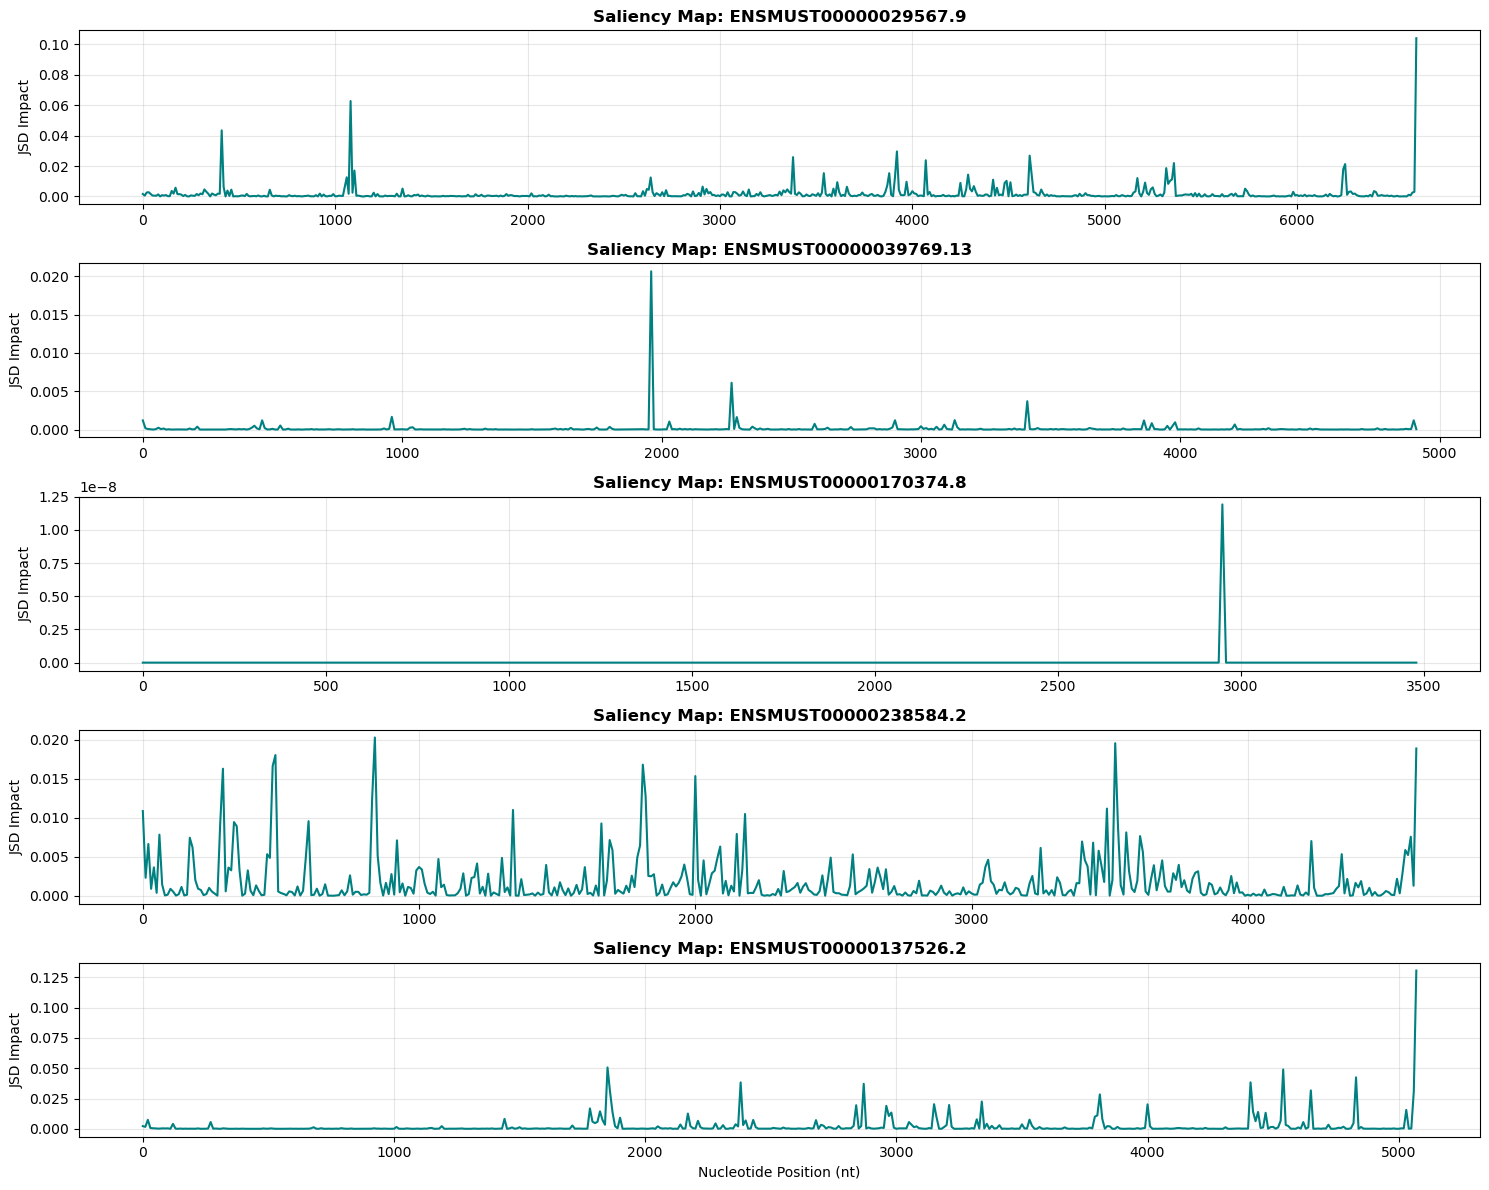

In [12]:
plt.figure(figsize=(15, 12))

for i, seq_id in enumerate(target_isoforms, 1):
    if i > 5:
        break
    
    df_map = saliency_results_2[seq_id]['map']
    
    plt.subplot(5, 1, i)
    plt.plot(df_map['start'], df_map['jsd'], color='teal', linewidth=1.5)
    
    # Add labels and formatting
    plt.title(f"Saliency Map: {seq_id}", fontsize=12, fontweight='bold')
    plt.ylabel("JSD Impact")
    if i == 5: plt.xlabel("Nucleotide Position (nt)")
    plt.grid(alpha=0.3)
    plt.tight_layout()

plt.show()

### extract the sequences

In [13]:
# CONFIGURATION
ROI_SIZE = 50
MASK_RADIUS = ROI_SIZE/2
MAX_ROIS = 3       
RATIO_THRESH = 0.6     
ABSOLUTE_THRESH = 1e-4

# Master Dictionary to store motifs
motif_registry_2 = {}

processed_ids = list(saliency_results_2.keys())
print(f"Extracting up to {MAX_ROIS} motifs for {len(processed_ids)} transcripts...")

motifs_num = 0
for seq_id in processed_ids:
    # 1. Get the map and sequence
    df_map = saliency_results_2[seq_id]['map'].copy()
    try:
        original_text = next(s[1] for s in raw_data if str(s[0]) == str(seq_id))
    except StopIteration:
        continue # Skip if seq not found
        
    seq_len = len(original_text)
    motifs_found = []
    
    # 2. Find Global Max
    if df_map.empty: continue
    max_jsd = df_map['jsd'].max()
    
    # 3. Iterative Peak Picking
    for i in range(MAX_ROIS):
        # Safety check: if all peaks masked or max is 0
        current_max = df_map['jsd'].max()
        if current_max <= ABSOLUTE_THRESH: 
            break 
        
        # STOP if this peak is too weak compared to the PRIMARY peak
        if current_max < (max_jsd * RATIO_THRESH):
            break

        # Find current highest point
        peak_idx = df_map['jsd'].idxmax()
        peak_val = df_map.loc[peak_idx, 'jsd']
        peak_pos = df_map.loc[peak_idx, 'start']
        # print(f'currently looking at location {peak_pos}')
        
        # Define window (clamped to sequence bounds)
        start_win = max(0, peak_pos - (ROI_SIZE // 2))
        end_win = min(seq_len, start_win + ROI_SIZE)
        
        # Adjust if hit the end
        if end_win == seq_len:
            start_win = max(0, seq_len - ROI_SIZE)
            
        roi_seq = original_text[start_win:end_win]
        
        # Store Motif Data
        motifs_found.append({
            'rank': i + 1,
            'peak_pos': peak_pos,
            'peak_jsd': peak_val,
            'sequence': roi_seq
        })
        
        # 4. MASK OUT this region
        mask_start = max(0, peak_pos - MASK_RADIUS)
        mask_end = min(seq_len, peak_pos + MASK_RADIUS)
        
        # Set JSD to 0 to ensure it's never picked again
        mask_condition = (df_map['start'] >= mask_start) & (df_map['start'] <= mask_end)
        df_map.loc[mask_condition, 'jsd'] = 0

    # Save to registry
    if motifs_found:
        motifs_num += len(motifs_found)
        motif_registry_2[seq_id] = motifs_found

print(f" Extraction complete. Registry contains {len(motif_registry_2)} transcripts and {motifs_num} motifs.")

Extracting up to 3 motifs for 1455 transcripts...
✅ Extraction complete. Registry contains 1123 transcripts and 2147 motifs.


### cluster the transcripts

In [14]:

buckets = {
    'chromatin_prob': 'chromatin',
    'cytoplasm_prob': 'cytoplasm',
    'cytosol_prob': 'cytosol',
    'endoplasmic reticulum_prob': 'ER',
    'extracellular region_prob': 'extracellular',
    'membrane_prob': 'membrane',
    'mitochondrion_prob': 'mitochondrion',
    'nucleolus_prob': 'nucleolus',
    'nucleoplasm_prob': 'nucleoplasm',
    'nucleus_prob': 'nucleus',
    'ribosome_prob': 'ribosome'
}

# Load Original Predictions
df_original = pd.read_csv("Prediction_correct.csv")
# Filter to only include the ones we have motifs for
df_subset = df_original[df_original['sequence_id'].isin(motif_registry_2.keys())].copy()

# Create the Hierarchy Dictionary
bucket_hierarchy_2 = {name: [] for name in buckets.values()}
K = 0.75

print(f"Sorting {len(df_subset)} transcripts into buckets...")

for _, row in df_subset.iterrows():
    seq_id = row['sequence_id']
    
    # Retrieve the motifs 
    motifs = motif_registry_2.get(seq_id, [])
    if not motifs: continue
    
    # Check against every bucket definition
    for col_name, bucket_name in buckets.items():
        # Find the actual column name in the CSV 
        real_col = next((c for c in df_subset.columns if col_name in c), None)
        
        # If the model predicted this location
        if real_col and row[real_col] >= K:
            
            # Add this transcript AND its motifs to the bucket
            bucket_hierarchy_2[bucket_name].append({
                'sequence_id': seq_id,
                'probability': row[real_col],
                'motifs': motifs 
            })

# Validation
print("\n Hierarchy Built! Example Access:")
for b_name in bucket_hierarchy_2:
    count = len(bucket_hierarchy_2[b_name])
    if count > 0:
        print(f" Bucket ['{b_name}'] contains {count} transcripts.")


Sorting 1123 transcripts into buckets...

 Hierarchy Built! Example Access:
 Bucket ['chromatin'] contains 413 transcripts.
 Bucket ['cytoplasm'] contains 577 transcripts.
 Bucket ['cytosol'] contains 915 transcripts.
 Bucket ['ER'] contains 29 transcripts.
 Bucket ['extracellular'] contains 1112 transcripts.
 Bucket ['membrane'] contains 536 transcripts.
 Bucket ['mitochondrion'] contains 686 transcripts.
 Bucket ['nucleolus'] contains 564 transcripts.
 Bucket ['nucleoplasm'] contains 465 transcripts.
 Bucket ['nucleus'] contains 924 transcripts.
 Bucket ['ribosome'] contains 662 transcripts.


## Motif Identification

### export for MEME

In [15]:
def export_for_meme(bucket_hierarchy, output_dir="meme_input_2"):
    """Export motif sequences as FASTA files for MEME analysis."""
    os.makedirs(output_dir, exist_ok=True)
    
    for class_name, entries in bucket_hierarchy.items():
        if not entries:
            continue
            
        fasta_path = os.path.join(output_dir, f"{class_name}_motifs.fasta")
        
        with open(fasta_path, 'w') as f:
            seq_idx = 0
            for entry in entries:
                for motif in entry['motifs']:
                    seq_idx += 1
                    header = f">{entry['sequence_id']}_rank{motif['rank']}_pos{motif['peak_pos']}"
                    f.write(f"{header}\n{motif['sequence']}\n")
        
        print(f" Exported {seq_idx} sequences to {fasta_path}")

# Export all classes
export_for_meme(bucket_hierarchy_2)

 Exported 717 sequences to meme_input_2/chromatin_motifs.fasta
 Exported 1064 sequences to meme_input_2/cytoplasm_motifs.fasta
 Exported 1760 sequences to meme_input_2/cytosol_motifs.fasta
 Exported 53 sequences to meme_input_2/ER_motifs.fasta
 Exported 2120 sequences to meme_input_2/extracellular_motifs.fasta
 Exported 969 sequences to meme_input_2/membrane_motifs.fasta
 Exported 1299 sequences to meme_input_2/mitochondrion_motifs.fasta
 Exported 1038 sequences to meme_input_2/nucleolus_motifs.fasta
 Exported 826 sequences to meme_input_2/nucleoplasm_motifs.fasta
 Exported 1777 sequences to meme_input_2/nucleus_motifs.fasta
 Exported 1254 sequences to meme_input_2/ribosome_motifs.fasta
